<a href="https://colab.research.google.com/github/Daniel7363/genetic_programming/blob/main/Genetic_Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

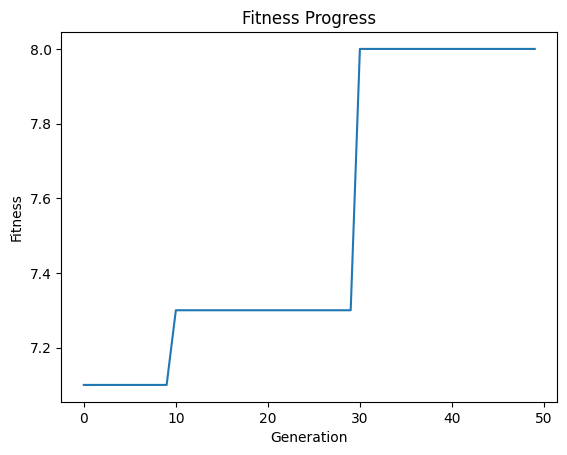

Best individual: ('OR', 'C', ('AND', 'B', 'A'))


In [52]:
import random
import operator
import matplotlib.pyplot as plt

# boolean operators
operators = {
    "AND": operator.and_,
    "OR": operator.or_,
    "NOT": lambda x: not x
}

# dataset: truth table for 3 variables (A, B, C)
variables = ['A', 'B', 'C']
dataset = [
    {'input': (0, 0, 0), 'output': 0},  # Target boolean expression: (A AND B) OR C
    {'input': (0, 0, 1), 'output': 1},
    {'input': (0, 1, 0), 'output': 0},
    {'input': (0, 1, 1), 'output': 1},
    {'input': (1, 0, 0), 'output': 0},
    {'input': (1, 0, 1), 'output': 1},
    {'input': (1, 1, 0), 'output': 1},
    {'input': (1, 1, 1), 'output': 1},
]

# Helper function to evaluate a tree
def evaluate_tree(tree, inputs):
    if isinstance(tree, str):  # Variable
        return inputs[variables.index(tree)]
    elif isinstance(tree, int):  # Constant
        return tree
    else:  # Operator
        func = operators[tree[0]]
        if tree[0] == "NOT":
            return func(evaluate_tree(tree[1], inputs))
        else:
            return func(evaluate_tree(tree[1], inputs), evaluate_tree(tree[2], inputs))

# Generate random individual (tree)
def random_individual(depth=3, max_depth=6):
    if depth >= max_depth or random.random() < 0.3:  # Leaf node condition
        return random.choice(variables + [0, 1])
    else:  # Internal node
        op = random.choice(list(operators.keys()))
        if op == "NOT":  # NOT is unary
            return (op, random_individual(depth + 1, max_depth))
        else:  # AND, OR are binary
            return (op, random_individual(depth + 1, max_depth), random_individual(depth + 1, max_depth))

def calculate_tree_size(tree):
    if isinstance(tree, (int, str)):  # Leaf node
        return 1
    elif len(tree) == 2:  # Unary operator (e.g., NOT)
        return 1 + calculate_tree_size(tree[1])
    elif len(tree) == 3:  # Binary operator (e.g., AND, OR)
        return 1 + calculate_tree_size(tree[1]) + calculate_tree_size(tree[2])

# Fitness function
def fitness(individual):
    correct = 0
    for data in dataset:
        if evaluate_tree(individual, data['input']) == data['output']:
            correct += 1

    # Calculate complexity penalty (based on tree depth or size)
    complexity = calculate_tree_size(individual)  # Number of nodes in the tree
    penalty = complexity * 0.1 if complexity > 5 else 0
    return correct - penalty


# Probabilistic Crossover
def probabilistic_crossover(parent1, parent2):
    # If either parent is a leaf node, randomly choose one of the parents
    if isinstance(parent1, (int, str)) or isinstance(parent2, (int, str)):
        return parent1 if random.random() < 0.5 else parent2

    # Probabilistic selection of subtrees based on parent fitness
    if random.random() < 0.7:  # Higher chance to select subtrees from the fitter parent
        return parent1
    elif random.random() < 0.7:
        return parent2

    # Swap subtrees
    if len(parent1) == 3 and len(parent2) == 3:  # Binary operators
        return (
            parent1[0],  # Operator
            probabilistic_crossover(parent1[1], parent2[1]),  # Left subtree
            probabilistic_crossover(parent1[2], parent2[2])   # Right subtree
        )
    elif len(parent1) == 2 and len(parent2) == 2:  # Unary operators
        return (
            parent1[0],  # Operator
            probabilistic_crossover(parent1[1], parent2[1])   # Single subtree
        )
    else:
        return parent1 if random.random() < 0.5 else parent2

# Dynamic Mutation Rate
def dynamic_mutate(individual, generation, max_generations, max_depth=5, max_prob=0.3, min_prob=0.01):
    mutation_prob = max_prob - (generation / max_generations) * (max_prob - min_prob)
    if random.random() < mutation_prob:
        return random_individual(depth=0, max_depth=max_depth)  # Generate with depth limit
    elif isinstance(individual, (int, str)):
        return individual
    elif individual[0] == "NOT":
        return (individual[0], dynamic_mutate(individual[1], generation, max_generations, max_depth))
    else:
        return (
            individual[0],
            dynamic_mutate(individual[1], generation, max_generations, max_depth),
            dynamic_mutate(individual[2], generation, max_generations, max_depth)
        )


# Dynamic Population Size
def dynamic_population_size(fitness_progress, population, max_size=200, min_size=50):
    # Increase size if fitness stagnates (no improvement for 5 generations)
    if len(fitness_progress) > 5 and fitness_progress[-1] == fitness_progress[-5]:
        return min(len(population) + 10, max_size)
    # Decrease size if fitness improves significantly
    elif len(fitness_progress) > 5 and fitness_progress[-1] > fitness_progress[-5]:
        return max(len(population) - 10, min_size)
    return len(population)

# Selection (tournament)
def select(population, k=10):
    tournament = random.sample(population, k)
    return max(tournament, key=fitness)

# GP process with enhancements
def genetic_programming(generations=50, population_size=100):
    population = [random_individual() for _ in range(population_size)]
    fitness_progress = []

    for generation in range(generations):
        # Evaluate fitness
        population = sorted(population, key=fitness, reverse=True)
        fitness_progress.append(fitness(population[0]))

        # Elitism: Preserve the best individual
        elite = population[0]

        # Dynamic Population Size
        new_size = dynamic_population_size(fitness_progress, population)
        new_population = []

        # Create new population with probabilistic crossover and dynamic mutation
        for _ in range(new_size - 1):  # Reserve space for elite
            parent1 = select(population)
            parent2 = select(population)
            child = dynamic_mutate(probabilistic_crossover(parent1, parent2), generation, generations)
            new_population.append(child)

        # Add elite to the new population
        new_population.append(elite)
        population = new_population

    # Plot fitness progress
    plt.plot(fitness_progress)
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Progress')
    plt.show()

    return population[0]

# Run GP
best_individual = genetic_programming()
print("Best individual:", best_individual)
